# Boosting Classification

In this notebook, I will work through a simple boosting classifier. I will use the breast cancer classification dataset.

In [1]:
## imports ##
import numpy as np
import pandas as pd
from typing import Dict, Any, List
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,make_scorer
from sklearn.ensemble import RandomForestClassifier

We can now create the class that will encapsulate the boosting algorithm:

In [2]:
## boosting classifier ##
class BoostingClassifier(object):
    #initializer
    def __init__(self, 
                 weak_learner : Any, 
                 n_elements : int = 100, 
                 learning_rate : float = 0.01, 
                 record_training_f1 : bool = False) -> None:
        self.weak_learner  = weak_learner
        self.n_elements    = n_elements
        self.learning_rate = learning_rate
        self.f             = []
        self.model_weights = []
        self.f1s           = []
        self.record_f1s    = record_training_f1
        
    #destructor
    def __del__(self) -> None:
        del self.weak_learner
        del self.n_elements
        del self.learning_rate
        del self.f
        del self.model_weights
        del self.f1s
    
    #public function to return model parameters
    def get_params(self, deep : bool = False) -> Dict:
        return {'weak_learner':self.weak_learner,'n_elements':self.n_elements,'learning_rate':self.learning_rate}
    
    #public function to train the ensemble
    def fit(self, X_train : np.array, y_train : np.array) -> None:
        #initialize sample weights, residuals, & model array
        w              = np.ones((y_train.shape[0]))
        self.residuals = []
        self.f         = []
        #loop through the specified number of iterations in the ensemble
        for _ in range(self.n_elements):
            #make a copy of the weak learner
            model = clone(self.weak_learner)
            #fit the weak learner on the current dataset
            model.fit(X_train,y_train,sample_weight=w)
            #update the sample weights
            y_pred = model.predict(X_train)
            m      = y_pred != y_train
            w[m]  *= np.exp(self.learning_rate)
            #append resulting model
            self.f.append(model)
            #append current count of correctly labeled samples
            self.model_weights.append(np.sum(y_pred == y_train))
            #append current f1 score
            if self.record_f1s:
                self.f1s.append(self.__compute_f1(X_train,y_train))
        #normalize the model weights
        self.model_weights /= np.sum(self.model_weights)
      
    # private function to compute f1 score for n-trained weak learners
    def __compute_f1(self, X_train : np.array, y_train : np.array) -> float:
        #initialize output
        y_pred = np.zeros((X_train.shape[0]))
        #normalize model weights
        n_model_weights = self.model_weights/np.sum(self.model_weights)
        #traverse ensemble to generate predictions
        for model,mw in zip(self.f,n_model_weights):
            y_pred += mw*model.predict_proba(X_train)[:,1]
        #combine output from ensemble
        y_pred = np.round(y_pred).astype(int)
        #return computed f1 score
        return(f1_score(y_train,y_pred))
    
    #public function to return training f1 scores
    def get_f1s(self) -> List:
        return(self.f1s)
    
    #public function to generate predictions
    def predict(self, X_test : np.array) -> np.array:
        #initialize output
        y_pred = np.zeros((X_test.shape[0]))
        #traverse ensemble to generate predictions
        for model,mw in zip(self.f,self.model_weights):
            y_pred += mw*model.predict_proba(X_test)[:,1]
        #combine output from ensemble
        y_pred = np.round(y_pred).astype(int)
        #return predictions
        return(y_pred)

## Boosting Classification

### Load Classification Dataset

Here I'll load the breast cancer dataset. Note I already analysed these data in Article II - Logistic Regression.

In [3]:
## load classification dataset
data = load_breast_cancer()
X    = data.data
y    = data.target

### Investigate F1 Score

In this section I want to check the effects of increasing ensemble size versus learning rate. Specifically, we'll check that the F1 score of the ensemble increases as more weak learners are added. I will also setup the weak learner, which in our case will be a classification decision stump:

In [4]:
## initialize a weak learner ##
weak_m = DecisionTreeClassifier(max_depth=1)

In [5]:
## set the learning rates to try ##
learning_rates = [0.1,0.01,0.001,0.0001]

In [8]:
## loop through the learning rates, record F1 scores ##
dfF1 = pd.DataFrame()
for lr in learning_rates:

    #declare a boosting regressor
    clf = BoostingClassifier(weak_learner=weak_m, n_elements=1000, learning_rate=lr, record_training_f1=True)
    
    #fit the model
    clf.fit(X,y)
    
    #record F1 scores
    dfF1[str(lr)] = clf.get_f1s()

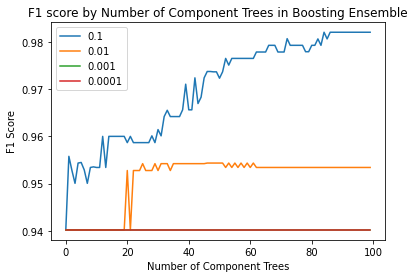

In [7]:
## plot the F1 scores ##
dfF1.plot()
plt.title('F1 score by Number of Component Trees in Boosting Ensemble')
plt.xlabel('Number of Component Trees')
plt.ylabel('F1 Score')
plt.show()

F1 scores increase as number of component trees increases in the ensemble. Let's see what happens if we run the above code again, but this time going up to 1000 trees:

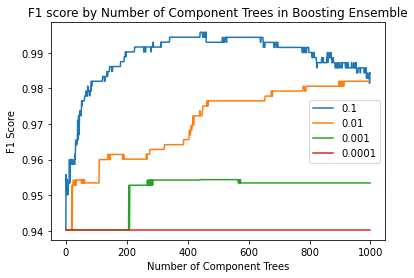

In [9]:
## plot the F1 scores ##
dfF1.plot()
plt.title('F1 score by Number of Component Trees in Boosting Ensemble')
plt.xlabel('Number of Component Trees')
plt.ylabel('F1 Score')
plt.show()

### Investigate Performance

Here I will use 10-fold cross-validation to measure the performance of the boosting classifier:

In [10]:
## define the scoring metrics ##
scoring_metrics = {'accuracy' : make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score),
                   'recall'   : make_scorer(recall_score),
                   'f1'       : make_scorer(f1_score)}

In [11]:
## loop through each learning rate & evaluate for n_elements=100 ##
for lr in learning_rates:
    #define the model
    clf = BoostingClassifier(weak_learner=weak_m, n_elements=100, learning_rate=lr)
    #cross validate
    dcScores = cross_validate(clf,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
    #report results
    print('Learning Rate: ',lr)
    print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
    print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
    print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
    print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))
    print('')

Learning Rate:  0.1
Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.98
Mean F1: 0.97

Learning Rate:  0.01
Mean Accuracy: 0.92
Mean Precision: 0.92
Mean Recall: 0.96
Mean F1: 0.94

Learning Rate:  0.001
Mean Accuracy: 0.89
Mean Precision: 0.90
Mean Recall: 0.95
Mean F1: 0.92

Learning Rate:  0.0001
Mean Accuracy: 0.89
Mean Precision: 0.90
Mean Recall: 0.95
Mean F1: 0.92



In [12]:
## loop through each learning rate & evaluate for n_elements=1000 ##
for lr in learning_rates:
    #define the model
    clf = BoostingClassifier(weak_learner=weak_m, n_elements=1000, learning_rate=lr)
    #cross validate
    dcScores = cross_validate(clf,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
    #report results
    print('Learning Rate: ',lr)
    print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
    print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
    print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
    print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))
    print('')

Learning Rate:  0.1
Mean Accuracy: 0.94
Mean Precision: 0.99
Mean Recall: 0.92
Mean F1: 0.95

Learning Rate:  0.01
Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.98
Mean F1: 0.97

Learning Rate:  0.001
Mean Accuracy: 0.92
Mean Precision: 0.92
Mean Recall: 0.96
Mean F1: 0.94

Learning Rate:  0.0001
Mean Accuracy: 0.89
Mean Precision: 0.90
Mean Recall: 0.95
Mean F1: 0.92



Let's also analyse the weak learner on its own:

In [13]:
#cross validate
dcScores = cross_validate(weak_m,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
#report results
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))

Mean Accuracy: 0.89
Mean Precision: 0.89
Mean Recall: 0.95
Mean F1: 0.91


Finally let's also compare the results obtained above to those we can get using a Random Forest Classifier:

In [14]:
#declare random forest
clf = RandomForestClassifier()
#cross validate
dcScores = cross_validate(clf,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
#report results
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))

Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.98
Mean F1: 0.97


Model | Learning Rate | Number of Elements | Accuracy | Precision | Recall | F1
--- | --- | --- | --- | --- | --- | ---
Boosting Classifier | 0.1 | 100 | 0.96 | 0.96 | 0.98 | 0.97
Boosting Classifier | 0.01 | 100 | 0.92 | 0.92 | 0.96 | 0.94
Boosting Classifier | 0.001 | 100 | 0.89 | 0.90 | 0.95 | 0.92
Boosting Classifier | 0.0001 | 100 | 0.89 | 0.90 | 0.95 | 0.92
Boosting Classifier | 0.1 | 1000 | 0.94 | 0.99 | 0.92 | 0.95
Boosting Classifier | 0.01 | 1000 | 0.96 | 0.96 | 0.98 | 0.97
Boosting Classifier | 0.001 | 1000 | 0.92 | 0.92 | 0.96 | 0.94
Boosting Classifier | 0.0001 | 1000 | 0.89 | 0.90 | 0.95 | 0.92
Decision Tree Stump | NA | NA | 0.89 | 0.89 | 0.95 | 0.91
Scikit-Learn Random Forest | NA | NA | 0.96 | 0.96 | 0.98 | 0.97

It's apparant from these results that our simple boosting procedure can yield results that are a significant improvement over the solitary weak learner. It is also clear that the boosted classifier, with an optimized learning rate, can produce results that are on-par with those of the scikit-learn random forest with default settings.